In [3]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import random 

#import os
import sys
import numpy as np
import re
import matplotlib.patches as patches


In [2]:
cdrfile = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/results/MergedWindows/FinalMergedCDRs/Final_CDRCoordinates_AllSNPSets_Table_GeneTable.txt'

ROIarray = []
cdrFile = open(cdrfile, 'r')
for line in cdrFile:
    if 'Chrom' in line: #skips header
        continue
    line = line.rstrip().split('\t')
    coord = line[0] + ':' + line[1] + '-' + line[2]
    ROIarray.append([coord, line[3],line[5]])
    
print 'Processing %i CDRs' % (len(ROIarray))

Processing 37 CDRs


In [20]:
#Out directory for generated plots
plotDir = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/GenomePlots/'

#Non-overlap, Total callset
noTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/NoSliding/AutoXPar/village_wolf_mxb_rm_54callset_autoXpar_Hudson_Fst_200kbWindow.txt_filtered_windows_RofA_Fst_Zscores.txt'
#Overlap, Total callset
overTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/Sliding/AutoXPar/village_wolf_mxb_rm_54callset_autoXpar_Hudson_Fst_200kbWindow_50kbSlide.txt_filtered_windows_RofA_Fst_Zscores.txt'
#Per Site, Total callset
perTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/PerSite/Merged_VillageWolf_mxb_rm_PERSITE_54callset_AutoXParXNonPar_Hudson_Fst_PerSite_Zscores.txt'

#Reading into file array
fileArray = []
fileArray = [noTotal,overTotal,perTotal]

#Reading in CDR regions
cdrfile = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/results/MergedWindows/FinalMergedCDRs/Final_CDRCoordinates_AllSNPSets_Table.bed'

ROIarray = []
cdrFile = open(cdrfile, 'r')
for line in cdrFile:
    line = line.rstrip().split('\t')
    coord = line[0] + ':' + line[1] + '-' + line[2]
    ROIarray.append([coord, line[3]])

print 'Processing %i CDRs' % (len(ROIarray))

Processing 37 CDRs


In [29]:
##############################################################################################
def find_gene_pos():
    #GTF file with genes of interest:
    gtfFile = open('/home/ampend/kidd-lab/ampend-projects/BLAST2GO/ensembl_input/Canis_familiaris.CanFam3.1.81.gtf','r')

    #YOU NEED TO DO THIS BY HAND BY GREP'ING THE GTF FILE:
    #genesOfInterest = ['ENSCAFG00000028653','RNPC3','COL11A1']
    genesOfInterest = []
    genePos = []

    for line in gtfFile:
        if '#' in line:
            continue
        line=line.rstrip().split('\t')
        if 'exon' not in line[2]:
            continue
        chrom = 'chr' + line[0]
        start = int(line[3])
        end = int(line[4])
        direction = str(line[6])
        if chrom == ROIchrom:
            if start >= ROIstart and end <= ROIend:
                #Finding gene ID in line
                geneInfo = line[8]
                if 'gene_name' in geneInfo:
                    geneInfo = geneInfo.split(';')
                    geneInfo = geneInfo[5].split(' ')
                    geneID = geneInfo[2].replace('"','')
                else:
                    geneInfo = geneInfo.split(';')
                    geneInfo = geneInfo[0].split(' ')
                    geneID = geneInfo[1].replace('"','')
                if 'ENSCAFG00000028653' in geneID:
                    geneID = 'AMY2B'
                """for i in genesOfInterest:
                    if geneID == i:
                        genePos.append([geneID,start,end])"""
                if geneID not in genesOfInterest:
                    genesOfInterest.append(geneID)
                genePos.append([geneID,start,end,direction])
            else:
                continue
        else:
            continue
    gtfFile.close()
    return genesOfInterest,genePos
###################################################################
##LONG## 
def get_data():
    index=-1
    for file in fileArray:
        index += 1
        inFile = open(file,'r')
        for line in inFile:
            if 'Chrom' in line or 'CHROM' in line:
                continue
            line = line.rstrip().split('\t')
            if 'PerSite' in file:
                chrom,start,end,Z = line[0],int(line[1]),int(line[1]),float(line[3])
            else:
                chrom,start,end, Z = line[0],int(line[1]),int(line[2]),float(line[9])
            #Now check if the call is within the ROI
            if chrom == ROIchrom and start >= ROIstart and end <= ROIend:
                if '50kbSlide' in file: #OVERLAP WINDOW FILE
                    midpoint = float(start + end)/2
                    SlideArray.append([chrom,midpoint,Z])
                    continue
                if 'PerSite' in file: #PER SITE WINDOW FILE
                    perSiteArray.append([chrom,start,Z])
                    continue
                else: #NO OVERLAP WINDOW FILE
                    midpoint = float(start + end)/2
                    NoSlideArray.append([chrom,midpoint,Z])
                    continue                
                #outFile.write('%s\t%s\t%s\t%s\n' % (chrom,start,end,Z)) 
        inFile.close()
    return SlideArray,perSiteArray,NoSlideArray
####################################################################################
def get_fst():
    ##LONG## 
    index=-1
    perSiteArray, SlideArray, NoSlideArray = [] , [], []
    for file in fileArray:
        index += 1
        inFile = open(file,'r')
        for line in inFile:
            if 'Chrom' in line or 'CHROM' in line:
                continue
            line = line.rstrip().split('\t')
            if 'PerSite' in file:
                chrom,start,end,Z = line[0],int(line[1]),int(line[1]),float(line[3])
            else:
                chrom,start,end, Z = line[0],int(line[1]),int(line[2]),float(line[9])
            #Now check if the call is within the ROI
            if chrom == ROIchrom and start >= ROIstart and end <= ROIend:
                if '50kbSlide' in file: #OVERLAP WINDOW FILE
                    midpoint = float(start + end)/2
                    SlideArray.append([chrom,midpoint,Z])
                    continue
                if 'PerSite' in file: #PER SITE WINDOW FILE
                    perSiteArray.append([chrom,start,Z])
                    continue
                else: #NO OVERLAP WINDOW FILE
                    midpoint = float(start + end)/2
                    NoSlideArray.append([chrom,midpoint,Z])
                    continue                
    return perSiteArray, SlideArray, NoSlideArray
##############################################################################
def thin_snps():
    #THIS THINS THE MASSIVE LIST OF PER SITE ZFST VALUES
    percentage = float(50)
    k = int(len(perSiteArray) * percentage // 100)
    indices = random.sample(xrange(len(perSiteArray)), k)
    thinned_perSiteArray = [perSiteArray[i] for i in indices]
    return thinned_perSiteArray
#############################################################################
def determine_sig(NoSlideArray,SlideArray):
    passes = False
    plotArray = []
    for i in range(0,len(SlideArray)):
        x, y, width = SlideArray[i][1], SlideArray[i][2], 15000
        if y > 5:
            passes = True
    if passes == False:
        plotArray = NoSlideArray
        barColor = "green"
    else: 
        plotArray = SlideArray
        barColor = "red"
    return plotArray, barColor
#############################################################################
def draw_plot(ROIchrom,ROI_CDR, SlideArray, NoSlideArray,perSiteArray):
    plt.figure(figsize=(14,6))
    #plotArray, barColor = determine_sig(NoSlideArray,SlideArray)
    #PLOT LIMITS
    yMaximum = 9
    yMinimum = -9
    shortCDRs = ['CDR8','CDR2','CDR3','CDR14','CDR22']
    if ROI_CDR in shortCDRs: #especially for amylase and others with few genes
        yMinimum = -6
    #sliding window
    for i in range(0,len(SlideArray)):
        x, y, width = SlideArray[i][1], SlideArray[i][2], 15000
        if y > 5:
            plt.bar(x, y, width, color="red",alpha=0.6,linewidth=1)
            if y > yMaximum:
                yMaximum = y
        else:
            plt.bar(x, y, width, fill=False,alpha=0.6,linewidth=1)
    #NO sliding window
    for i in range(0,len(NoSlideArray)):
        x, y, width = NoSlideArray[i][1]-15000, NoSlideArray[i][2], 15000
        if y > 5:
            plt.bar(x, y, width, color="green",alpha=0.6,linewidth=1)
        else:
            plt.bar(x, y, width, fill=False,alpha=0.6,linewidth=1)
    """#SNPs
    for i in range(0,len(perSiteArray)):
        x,y =perSiteArray[i][1],perSiteArray[i][2]
        if y > 5:
            plt.scatter(x,y,facecolor='red',edgecolor='k',s=20)
            if y > yMaximum:
                yMaximum = y
        else:
            plt.scatter(x,y,color='black',alpha=0.8,s=10)"""
    #DEFINING AXIS LIMS
    plt.ylim(yMinimum,yMaximum+0.5)
    plt.xlim(ROIstart,ROIend)
    ax = plt.axes()
    #DRAwING GENE MODELS
    ###mp = []
    IDheights=[-3.5,-4.5,-5.5,-6.5,-7.5,-8.5]
    geneheights=[-3,-4,-5,-6,-7,-8]
    index = -1
    for gene in genesOfInterest:
        xRange = []
        #determines height to print the genes and gene IDs
        if index == 5:
            index = 0
        else:
            index += 1
        for i in range(0,len(genePos)):
            if gene == genePos[i][0]:
                x = genePos[i][1]
                direction = genePos[i][3]
                length = genePos[i][2]-genePos[i][1]
                #ax.add_patch(patches.Rectangle((x, -3),length,0.75,facecolor="black"))
                ax.add_patch(patches.Rectangle((x,geneheights[index]),length,0.75,facecolor="black"))
                xRange.append(x)
        xMin,xMax = min(xRange),max(xRange)
        if direction == '-':
            plt.plot(xMin-0.25, geneheights[index]+0.4, marker='<',color="blue")
        if direction == '+':
            plt.plot(xMax+0.25, geneheights[index]+0.4, marker='>',color="blue")
        plt.hlines(y=geneheights[index]+0.4, xmin=xMin, xmax=xMax,lw=1,color="black")
        #ADDING GENE TEXT
        if 'ENSCAFG' in gene:
            gene = gene.replace('ENSCAFG','ENS')
        geneMidpoint = ((xMax+xMin)/2)-10000
        if geneMidpoint < ROIend-10000: #Make sure the gene ID doesn't get printed off the plot
            #ax.text(xMax+2500,geneheights[index]+0.3,gene,fontsize=7)
            print geneMidpoint,geneheights[index]-0.4
            ax.text(geneMidpoint,geneheights[index]-0.4,gene,fontsize=7)
    #ADDING TITLES
    plt.xlabel('Chromosome %s Position' % (ROIchrom.replace("chr","")),fontsize=20)
    plt.ylabel(r'$ZF_{ST}$',fontsize=20)
    plt.title('Per Site and Window ZFst for %s' % ROI_CDR)
    #Add CDR window
    CDR = [ROIstart+210000,ROIend-210000]
    if 'CDR20' in ROI_CDR:
        CDR = [ROIstart+100000,ROIend-100000]
    ax.add_patch(patches.Rectangle((CDR[0], -1.75),(CDR[1]-CDR[0]),0.5,fill=None))
    ax.text(((ROIstart+ROIend)/2-10000), -1.7,str(ROI_CDR))
    ax.ticklabel_format(useOffset=False,style='plain')#turn off sci-notation in  xaxis labelling
    plt.savefig(plotDir + ROI_CDR + 'Locus_ZFstPlotWithGeneModels.png')
#############################################################################



#########
chr1:2300000-3250000

#########
chr1:79800000-80150000

#########
chr3:18800000-19050000

#########
chr4:40800000-41000000

#########
chr5:3850000-4250000

#########
chr6:39900000-40100000

#########
chr6:40350000-40950000

#########
chr6:46800000-47350000

#########
chr7:5000000-5300000

#########
chr9:8950000-9300000

#########
chr9:9950000-10850000

#########
chr9:12600000-12850000

#########
chr9:13150000-14650000

#########
chr10:3950000-4150000

#########
chr10:44600000-44850000

#########
chr11:52150000-52400000

#########
chr11:52700000-52950000

#########
chr13:3650000-3950000

#########
chr14:7200000-7550000

#########
chr16:7050000-7400000
CDR20
Looking for the Fst information for these coordinates: chr16 6950000 7500000

Genes of Interest in Region of Interest:
['TRBV3-1', 'ENSCAFG00000003818', 'ENSCAFG00000003820', 'PRSS58', 'ENSCAFG00000003827', 'ENSCAFG00000029181', 'ENSCAFG00000030973', 'ENSCAFG00000030631', 'MGAM2', 'MGAM', 'TAS2R38', 'CLEC5A', 'ENSCAFG00000

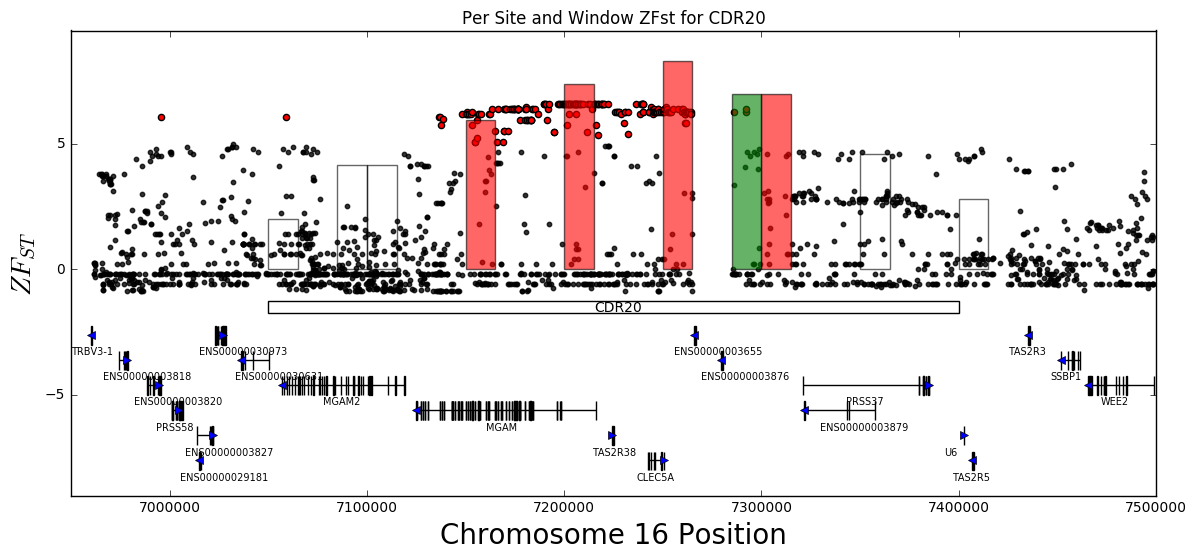

In [30]:
for i in range(0,len(ROIarray)):
    ROI =  ROIarray[i][0]
    print '\n#########\n',ROI
    ROIchrom,pos = ROI.split(':')
    ROI_CDR = ROIarray[i][1]
    if 'CDR20' not in ROI_CDR:
        continue
    print ROI_CDR
    ROIstart,ROIend = pos.split('-')
    if 'CDR20' in ROI_CDR:
        ROIstart,ROIend = int(ROIstart)-100000,int(ROIend)+100000
    else:
        ROIstart,ROIend = int(ROIstart)-210000,int(ROIend)+210000
    #DETERMINE FILES TO READ BASED OFF OF WHICH SNP TYPES WERE SIGNIFICANT PER CDR
    """if 'Set 2' in ROIarray[i][2]:
        Dir = '~/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Callset3_NewWorldWolvesRemoved/'
        #Non-overlap, NWW callset, autosome
        #noTotal = '~/kidd-lab/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Callset3_NewWorldWolvesRemoved/NoSliding/AutoXPar/village_wolf_NWwolves_rm_CallSet3Sites_autoXpar_Hudson_Fst_200kbWindow.txt_filtered_windows_RofA_Fst_Zscores.txt'
        #noTotal = Dir + 'NoSliding/' + 'AutoXPar/' + 'village_wolf_NWwolves_rm_CallSet3Sites_autoXpar_Hudson_Fst_200kbWindow.txt_filtered_windows_RofA_Fst_Zscores.txt'
        noTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Callset3_NewWorldWolvesRemoved/NoSliding/AutoXPar/village_wolf_mxb_rm_CallSet3Sites_autoXpar_Hudson_Fst_200kbWindow.txt_filtered_windows_RofA_Fst_Zscores.txt'

        #Overlap, NWW callset 
        overTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Callset3_NewWorldWolvesRemoved/Sliding/AutoXPar/village_wolf_NWwolves_rm_CallSet3Sites_autoXpar_Hudson_Fst_200kbWindow_50kbSlide.txt_filtered_windows_RofA_Fst_Zscores.txt'
        if 'chrX' in ROIchrom:
            #Non-overlap, NWW callset, chrX
            noTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Callset3_NewWorldWolvesRemoved/NoSliding/XNonPar/village_wolf_NWwolves_rm_CallSet3Sites_Xnonpar_Hudson_Fst_200kbWindow.txt_filtered_windows_RofA_Fst_Zscores.txt'
            #Non-overlap, NWW callset, chrX
            overTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Callset3_NewWorldWolvesRemoved/Sliding/XNonPar/village_wolf_NWwolves_rm_CallSet3Sites_Xnonpar_Hudson_Fst_200kbWindow_50kbSlide.txt_filtered_windows_RofA_Fst_Zscores.txt'

    else:
        #Non-overlap, Total callset
        noTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/NoSliding/AutoXPar/village_wolf_mxb_rm_54callset_autoXpar_Hudson_Fst_200kbWindow.txt_filtered_windows_RofA_Fst_Zscores.txt'
        #Overlap, Total callset
        overTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/Sliding/AutoXPar/village_wolf_mxb_rm_54callset_autoXpar_Hudson_Fst_200kbWindow_50kbSlide.txt_filtered_windows_RofA_Fst_Zscores.txt'
        if 'chrX' in ROIchrom:
            #Non-overlap, Total callset
            noTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/NoSliding/XNonPar/village_wolf_mxb_rm_54callset_Xnonpar_Hudson_Fst_200kbWindow.txt_filtered_windows_RofA_Fst_Zscores.txt'
            #Overlap, Total callset
            overTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/Sliding/XNonPar/village_wolf_mxb_rm_54callset_Xnonpar_Hudson_Fst_200kbWindow_50kbSlide.txt_filtered_windows_RofA_Fst_Zscores.txt'
    """        
    #ALWAYS SAME FOR ALL
    #Per Site, Total callset
    perTotal = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/PerSite/Merged_VillageWolf_mxb_rm_PERSITE_54callset_AutoXParXNonPar_Hudson_Fst_PerSite_Zscores.txt'

    #Reading into file array
    fileArray = []
    fileArray = [noTotal,overTotal,perTotal]

    
    """if 'CDR6' in ROI_CDR:
        ROIstart,ROIend = 39800000,40200000"""
    print 'Looking for the Fst information for these coordinates:',ROIchrom,ROIstart,ROIend
    #Finding genes in the region
    genesOfInterest = []
    genePos = []
    genesOfInterest,genePos = find_gene_pos()

    print '\nGenes of Interest in Region of Interest:\n', genesOfInterest
    
    perSiteArray, SlideArray, NoSlideArray = get_fst()
    #thinned_perSiteArray = thin_snps()
    #perSiteArray = thinned_perSiteArray
    #length = len(thinned_perSiteArray)
    #print '%i SNPs went are found in this region' % length
    draw_plot(ROIchrom,ROI_CDR, SlideArray, NoSlideArray,perSiteArray)
    break

In [5]:
#PROCESSING CDR8 = AMY2B LOCUS ---- needs different parameters for main text figure
ROI = 'chr6:46500000-47500000'
ROIchrom,pos = ROI.split(':')
ROIstart,ROIend = pos.split('-')
ROIstart,ROIend = int(ROIstart),int(ROIend)
print 'Looking for the Fst information for these coordinates:',ROIchrom,ROIstart,ROIend

#Finding genes in the region
genesOfInterest = []
genePos = []
genesOfInterest,genePos = find_gene_pos()

print '\nGenes of Interest in Region of Interest:\n', genesOfInterest

Looking for the Fst information for these coordinates: chr6 46500000 47500000

Genes of Interest in Region of Interest:
['AMY2B', 'RNPC3', 'COL11A1']


In [6]:
##LONG## 
outDir = plotDir + 'AMY2B/'
index=-1

perSiteArray, SlideArray, NoSlideArray = [] , [], []

for file in fileArray:
    index += 1
    inFile = open(file,'r')
    for line in inFile:
        if 'Chrom' in line or 'CHROM' in line:
            continue
        line = line.rstrip().split('\t')
        if 'PerSite' in file:
            chrom,start,end,Z = line[0],int(line[1]),int(line[1]),float(line[3])
        else:
            chrom,start,end, Z = line[0],int(line[1]),int(line[2]),float(line[9])
        #Now check if the call is within the ROI
        if chrom == ROIchrom and start >= ROIstart and end <= ROIend:
            if '50kbSlide' in file: #OVERLAP WINDOW FILE
                midpoint = float(start + end)/2
                SlideArray.append([chrom,midpoint,Z])
                continue
            if 'PerSite' in file: #PER SITE WINDOW FILE
                perSiteArray.append([chrom,start,Z])
                continue
            else: #NO OVERLAP WINDOW FILE
                midpoint = float(start + end)/2
                NoSlideArray.append([chrom,midpoint,Z])
                continue                
            #outFile.write('%s\t%s\t%s\t%s\n' % (chrom,start,end,Z))    

In [ ]:
import random 
#THIS THINS THE MASSIVE LIST OF PER SITE ZFST VALUES
percentage = float(50)
k = int(len(perSiteArray) * percentage // 100)
indices = random.sample(xrange(len(perSiteArray)), k)
thinned_perSiteArray = [perSiteArray[i] for i in indices]

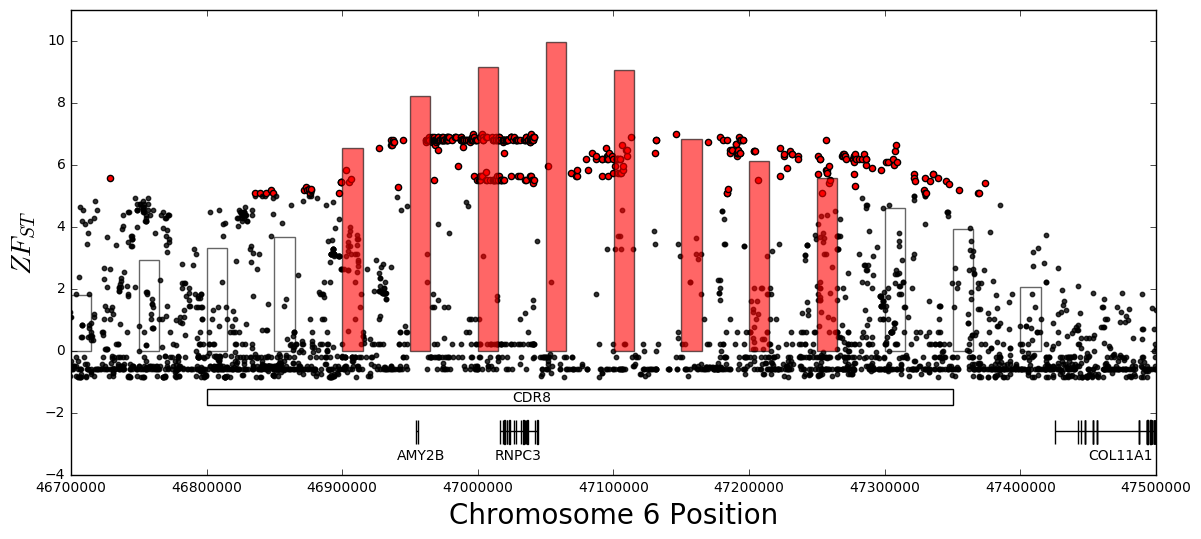

In [8]:
plt.figure(figsize=(14,6))

for i in range(0,len(SlideArray)):
    x = SlideArray[i][1]
    y = SlideArray[i][2]
    if x > 47500000:
        continue
    width = 15000
    if y > 5:
        plt.bar(x, y, width, color="red",alpha=0.6,linewidth=1)
    else:
        plt.bar(x, y, width, fill=False,alpha=0.6,linewidth=1)


"""for i in range(0,len(NoSlideArray)):
    x = NoSlideArray[i][1]-15000
    y = NoSlideArray[i][2]
    if x > 47500000:
        continue
    width = 15000
    if y > 5:
        plt.bar(x, y, width, color="red",alpha=0.6,hatch='//')
    else:
        plt.bar(x, y, width, fill=False,alpha=0.6,hatch='//')
"""        
for i in range(0,len(perSiteArray)):
    x = perSiteArray[i][1]
    y = perSiteArray[i][2]
    if x > 47500000:
        continue
    if y > 5:
        plt.scatter(x,y,facecolor='red',edgecolor='k',s=20)
    else:
        plt.scatter(x,y,color='black',alpha=0.8,s=10)

plt.ylim(-4,11)
plt.xlim(46700000,47500000)
ax = plt.axes()
#DRAwING GENE MODELS
IDheights=[-3.5,-4.5,-5.5,-6.5,-7.5,-8.5]
geneheights=[-3,-4,-5,-6,-7,-8]
mp = []

for gene in genesOfInterest:
    xRange = []
    for i in range(0,len(genePos)):
        if gene == genePos[i][0]:
            x = genePos[i][1]
            length = genePos[i][2]-genePos[i][1]
            ax.add_patch(patches.Rectangle((x, -3),length,0.75,facecolor="black"))
            xRange.append(x)
    xMin,xMax = min(xRange),max(xRange)
    plt.hlines(y=-2.6, xmin=xMin, xmax=xMax,lw=1,color="black")
    midpoint = np.mean(xRange)
    mp.append(midpoint)
    #indicating gene direction
    direction = genePos[i][3]
    if direction == '-':
        plt.plot(xMin-0.25, geneheights[index]+0.4, marker='<',color="blue")
    if direction == '+':
        plt.plot(xMax+0.25, geneheights[index]+0.4, marker='>',color="blue")
plt.xlabel('Chromosome 6 Position',fontsize=20)
plt.ylabel(r'$ZF_{ST}$',fontsize=20)

#Add gene IDs
#MANUAL
ax.text(46940000,-3.5,'AMY2B')
ax.text(47012000,-3.5,'RNPC3')
ax.text(47450000,-3.5,'COL11A1')
#Add CDR8 window
CDR8 = [46800001,47350000]
ax.add_patch(patches.Rectangle((CDR8[0], -1.75),(CDR8[1]-CDR8[0]),0.5,fill=None))
ax.text(47025000, -1.65,'CDR8')
#turn off sci-notation in  xaxis labelling
ax.ticklabel_format(useOffset=False,style='plain') 

plt.savefig(outDir + 'AMY2B_Locus_ZFstPlotWithGeneModels.png')

In [ ]:
plt.figure(figsize=(14,6))

for i in range(0,len(SlideArray)):
    x = SlideArray[i][1]
    y = SlideArray[i][2]
    if x > 47500000:
        continue
    width = 15000
    if y > 5:
        plt.bar(x, y, width, color="red",alpha=0.6,linewidth=1)
    else:
        plt.bar(x, y, width, fill=False,alpha=0.6,linewidth=1)

for i in range(0,len(perSiteArray)):
    x = perSiteArray[i][1]
    y = perSiteArray[i][2]
    if x > 47500000:
        continue
    if y > 5:
        plt.scatter(x,y,facecolor='red',edgecolor='k',s=20)
    else:
        plt.scatter(x,y,color='black',s=10)

plt.ylim(-4,11)
plt.xlim(46700000,47500000)
ax = plt.axes()

mp = []
for gene in genesOfInterest:
    xRange = []
    for i in range(0,len(genePos)):
        if gene == genePos[i][0]:
            x = genePos[i][1]
            length = genePos[i][2]-genePos[i][1]
            ax.add_patch(patches.Rectangle((x, -3),length,0.75,facecolor="black"))
            xRange.append(x)
    xMin,xMax = min(xRange),max(xRange)
    plt.hlines(y=-2.6, xmin=xMin, xmax=xMax,lw=1,color="black")
    midpoint = np.mean(xRange)
    mp.append(midpoint)

plt.xlabel('Chromosome 6 Position',fontsize=20)
plt.ylabel(r'$ZF_{ST}$',fontsize=20)

#Add gene IDs
#MANUAL
ax.text(46940000,-3.5,'AMY2B')
ax.text(47012000,-3.5,'RNPC3')
ax.text(47450000,-3.5,'COL11A1')
#Add CDR8 window
CDR8 = [46800001,47350000]
ax.add_patch(patches.Rectangle((CDR8[0], -1.75),(CDR8[1]-CDR8[0]),0.5,fill=None))
ax.text(47025000, -1.65,'CDR8')
#turn off sci-notation in  xaxis labelling
ax.ticklabel_format(useOffset=False,style='plain') 

plt.savefig(outDir + 'AMY2B_Locus_ZFstPlotWithGeneModels_NoPerSiteThinning.png')

In [ ]:
#PROCESSING CDR20 = MGAM LOCUS

ROI = 'chr16:7050001-7400000'
ROIchrom,pos = ROI.split(':')
ROIstart,ROIend = pos.split('-')
ROIstart,ROIend = int(ROIstart)-100000,int(ROIend)+100000
print 'Looking for the Fst information for these coordinates:',ROIchrom,ROIstart,ROIend

#Finding genes in the region
genesOfInterest = []
genePos = []
genesOfInterest,genePos = find_gene_pos()

print '\nGenes of Interest in Region of Interest:\n', genesOfInterest

#Get the data:
outDir = plotDir + 'CDR20/'
perSiteArray, SlideArray, NoSlideArray = [] , [], []
SlideArray,perSiteArray,NoSlideArray = get_data()
print '\n%i data points in Sliding (Overlapping) Fst data' % (len(SlideArray))
print '%i data points in No Sliding (Non-Overlapping) Fst data' % (len(NoSlideArray))
print '%i data points in Per Site Fst data' % (len(perSiteArray))

In [ ]:
import random 
#THIS THINS THE MASSIVE LIST OF PER SITE ZFST VALUES
percentage = float(50)
k = int(len(perSiteArray) * percentage // 100)
indices = random.sample(xrange(len(perSiteArray)), k)
thinned_perSiteArray = [perSiteArray[i] for i in indices]

In [ ]:
plt.figure(figsize=(14,6))

for i in range(0,len(SlideArray)):
    x = SlideArray[i][1]
    y = SlideArray[i][2]
    if x > 47500000:
        continue
    width = 15000
    if y > 5:
        plt.bar(x, y, width, color="red",alpha=0.6,linewidth=1)
    else:
        plt.bar(x, y, width, fill=False,alpha=0.6,linewidth=1)


"""for i in range(0,len(NoSlideArray)):
    x = NoSlideArray[i][1]-15000
    y = NoSlideArray[i][2]
    if x > 47500000:
        continue
    width = 15000
    if y > 5:
        plt.bar(x, y, width, color="red",alpha=0.6,hatch='//')
    else:
        plt.bar(x, y, width, fill=False,alpha=0.6,hatch='//')
"""        
for i in range(0,len(thinned_perSiteArray)):
    x = thinned_perSiteArray[i][1]
    y = thinned_perSiteArray[i][2]
    if y > 5:
        plt.scatter(x,y,facecolor='red',edgecolor='k',s=20)
    else:
        plt.scatter(x,y,color='black',alpha=0.8,s=10)

#DEFINING AXIS LIMS
plt.ylim(-9,8.5)
plt.xlim(ROIstart,ROIend)
ax = plt.axes()
#DRAwING GENE MODELS
mp = []
IDheights=[-3.5,-4.5,-5.5,-6.5,-7.5,-8.5]
geneheights=[-3,-4,-5,-6,-7,-8]
index = -1
for gene in genesOfInterest:
    xRange = []
    #determines height to print the genes and gene IDs
    if index == 5:
        index = 0
    else:
        index += 1
    for i in range(0,len(genePos)):
        if gene == genePos[i][0]:
            x = genePos[i][1]
            length = genePos[i][2]-genePos[i][1]
            #ax.add_patch(patches.Rectangle((x, -3),length,0.75,facecolor="black"))
            ax.add_patch(patches.Rectangle((x,geneheights[index]),length,0.75,facecolor="black"))
            xRange.append(x)
    xMin,xMax = min(xRange),max(xRange)
    #plt.hlines(y=-2.6, xmin=xMin, xmax=xMax,lw=1,color="black")
    plt.hlines(y=geneheights[index]+0.4, xmin=xMin, xmax=xMax,lw=1,color="black")
    midpoint = np.mean(xRange)
    mp.append(midpoint)
    #ADDING GENE TEXT
    if 'ENSCAFG' in gene:
        gene = gene.replace('ENSCAFG','ENS')
    if xMax < ROIend-10000: #Make sure the gene ID doesn't get printed off the plot
        ax.text(xMax+2500,geneheights[index]+0.3,gene,fontsize=7)
#ADDING TITLES
plt.xlabel('Chromosome 6 Position',fontsize=20)
plt.ylabel(r'$ZF_{ST}$',fontsize=20)

#Add CDR20 window
CDR20 = [ROIstart+100000,ROIend-100000]
ax.add_patch(patches.Rectangle((CDR20[0], -1.75),(CDR20[1]-CDR20[0]),0.5,fill=None))
ax.text(((ROIstart+ROIend)/2-10000), -1.7,'CDR20')
#turn off sci-notation in  xaxis labelling
ax.ticklabel_format(useOffset=False,style='plain') 

plt.savefig(outDir + 'CDR20_Locus_ZFstPlotWithGeneModels.png')

In [ ]:
#PROCESSING CDR10 

ROI = 'chr9:8950001-9300000'
ROIchrom,pos = ROI.split(':')
ROIstart,ROIend = pos.split('-')
ROIstart,ROIend = int(ROIstart)-100000,int(ROIend)+100000
print 'Looking for the Fst information for these coordinates:',ROIchrom,ROIstart,ROIend

#Finding genes in the region
genesOfInterest = []
genePos = []
genesOfInterest,genePos = find_gene_pos()

print '\nGenes of Interest in Region of Interest:\n', genesOfInterest

#Get the data:
outDir = plotDir + 'CDR20/'
perSiteArray, SlideArray, NoSlideArray = [] , [], []
SlideArray,perSiteArray,NoSlideArray = get_data()
print '\n%i data points in Sliding (Overlapping) Fst data' % (len(SlideArray))
print '%i data points in No Sliding (Non-Overlapping) Fst data' % (len(NoSlideArray))
print '%i data points in Per Site Fst data' % (len(perSiteArray))

In [ ]:
plt.figure(figsize=(14,6))

for i in range(0,len(SlideArray)):
    x = SlideArray[i][1]
    y = SlideArray[i][2]
    width = 15000
    if y > 5:
        plt.bar(x, y, width, color="red",alpha=0.6,linewidth=1)
    else:
        plt.bar(x, y, width, fill=False,alpha=0.6,linewidth=1)
    
for i in range(0,len(perSiteArray)):
    x = perSiteArray[i][1]
    y = perSiteArray[i][2]
    if y > 5:
        plt.scatter(x,y,facecolor='red',edgecolor='k',s=20)
    else:
        plt.scatter(x,y,color='black',alpha=0.8,s=10)

#DEFINING AXIS LIMS
plt.ylim(-9,8.5)
plt.xlim(ROIstart,ROIend)
ax = plt.axes()
#DRAwING GENE MODELS
mp = []
IDheights=[-3.5,-4.5,-5.5,-6.5,-7.5,-8.5]
geneheights=[-3,-4,-5,-6,-7,-8]
index = -1
for gene in genesOfInterest:
    xRange = []
    #determines height to print the genes and gene IDs
    if index == 5:
        index = 0
    else:
        index += 1
    for i in range(0,len(genePos)):
        if gene == genePos[i][0]:
            x = genePos[i][1]
            length = genePos[i][2]-genePos[i][1]
            #ax.add_patch(patches.Rectangle((x, -3),length,0.75,facecolor="black"))
            ax.add_patch(patches.Rectangle((x,geneheights[index]),length,0.75,facecolor="black"))
            xRange.append(x)
    xMin,xMax = min(xRange),max(xRange)
    #plt.hlines(y=-2.6, xmin=xMin, xmax=xMax,lw=1,color="black")
    plt.hlines(y=geneheights[index]+0.4, xmin=xMin, xmax=xMax,lw=1,color="black")
    midpoint = np.mean(xRange)
    mp.append(midpoint)
    #ADDING GENE TEXT
    if 'ENSCAFG' in gene:
        gene = gene.replace('ENSCAFG','ENS')
    if xMax < ROIend-10000: #Make sure the gene ID doesn't get printed off the plot
        ax.text(xMax+2500,geneheights[index]+0.3,gene,fontsize=7)
#ADDING TITLES
plt.xlabel('Chromosome 9 Position',fontsize=20)
plt.ylabel(r'$ZF_{ST}$',fontsize=20)

#Add CDR20 window
CDR20 = [ROIstart+100000,ROIend-100000]
ax.add_patch(patches.Rectangle((CDR20[0], -1.75),(CDR20[1]-CDR20[0]),0.5,fill=None))
ax.text(((ROIstart+ROIend)/2-10000), -1.7,'CDR10')
#turn off sci-notation in  xaxis labelling
ax.ticklabel_format(useOffset=False,style='plain') 

plt.savefig(outDir + 'CDR10_Locus_ZFstPlotWithGeneModels.png')

In [ ]:
#PROCESSING chr9 Locus 

ROI = 'chr9:8950001-14650000'
ROIchrom,pos = ROI.split(':')
ROIstart,ROIend = pos.split('-')
ROIstart,ROIend = int(ROIstart)-100000,int(ROIend)+100000
print 'Looking for the Fst information for these coordinates:',ROIchrom,ROIstart,ROIend

#Finding genes in the region
genesOfInterest = []
genePos = []
genesOfInterest,genePos = find_gene_pos()

print '\nGenes of Interest in Region of Interest:\n', genesOfInterest

#Get the data:
outDir = plotDir 
perSiteArray, SlideArray, NoSlideArray = [] , [], []
SlideArray,perSiteArray,NoSlideArray = get_data()
print '\n%i data points in Sliding (Overlapping) Fst data' % (len(SlideArray))
print '%i data points in No Sliding (Non-Overlapping) Fst data' % (len(NoSlideArray))
print '%i data points in Per Site Fst data' % (len(perSiteArray))

In [ ]:
import random 
#THIS THINS THE MASSIVE LIST OF PER SITE ZFST VALUES
percentage = float(50)
k = int(len(perSiteArray) * percentage // 100)
indices = random.sample(xrange(len(perSiteArray)), k)
thinned_perSiteArray = [perSiteArray[i] for i in indices]

In [ ]:
plt.figure(figsize=(14,6))

for i in range(0,len(SlideArray)):
    x = SlideArray[i][1]
    y = SlideArray[i][2]
    width = 15000
    if y > 5:
        plt.bar(x, y, width, color="red",alpha=0.6,linewidth=1)
    else:
        plt.bar(x, y, width, fill=False,alpha=0.6,linewidth=1)
        
for i in range(0,len(NoSlideArray)):
    x = NoSlideArray[i][1]-15000
    y = NoSlideArray[i][2]
    if x > 47500000:
        continue
    width = 15000
    if y > 5:
        plt.bar(x, y, width, color="green",alpha=0.6,hatch='//')
    else:
        plt.bar(x, y, width, fill=False,alpha=0.6,hatch='//')
        
for i in range(0,len(thinned_perSiteArray)):
    x = thinned_perSiteArray[i][1]
    y = thinned_perSiteArray[i][2]
    if y > 5:
        plt.scatter(x,y,facecolor='red',edgecolor='k',s=20)
    else:
        plt.scatter(x,y,color='black',alpha=0.8,s=10)

#DEFINING AXIS LIMS
plt.ylim(-9,8.5)
plt.xlim(ROIstart,ROIend)
ax = plt.axes()
#DRAwING GENE MODELS
mp = []
IDheights=[-3.5,-4.5,-5.5,-6.5,-7.5,-8.5]
geneheights=[-3,-4,-5,-6,-7,-8]
index = -1
for gene in genesOfInterest:
    xRange = []
    #determines height to print the genes and gene IDs
    if index == 5:
        index = 0
    else:
        index += 1
    for i in range(0,len(genePos)):
        if gene == genePos[i][0]:
            x = genePos[i][1]
            length = genePos[i][2]-genePos[i][1]
            #ax.add_patch(patches.Rectangle((x, -3),length,0.75,facecolor="black"))
            ax.add_patch(patches.Rectangle((x,geneheights[index]),length,0.75,facecolor="black"))
            xRange.append(x)
    xMin,xMax = min(xRange),max(xRange)
    #plt.hlines(y=-2.6, xmin=xMin, xmax=xMax,lw=1,color="black")
    plt.hlines(y=geneheights[index]+0.4, xmin=xMin, xmax=xMax,lw=1,color="black")
    midpoint = np.mean(xRange)
    mp.append(midpoint)
    #ADDING GENE TEXT
    if 'ENSCAFG' in gene:
        gene = gene.replace('ENSCAFG','ENS')
    if xMax < ROIend-10000: #Make sure the gene ID doesn't get printed off the plot
        ax.text(xMax+2500,geneheights[index]+0.3,gene,fontsize=7)
#ADDING TITLES
plt.xlabel('Chromosome 9 Position',fontsize=20)
plt.ylabel(r'$ZF_{ST}$',fontsize=20)

#Add CDR20 window
#CDR = [ROIstart+100000,ROIend-100000]
#ax.add_patch(patches.Rectangle((CDR[0], -1.75),(CDR20[1]-CDR20[0]),0.5,fill=None))
#ax.text(((ROIstart+ROIend)/2-10000), -1.7,'CDR10')
#turn off sci-notation in  xaxis labelling
ax.ticklabel_format(useOffset=False,style='plain') 

plt.savefig(outDir + 'Chr9Locus_ZFstPlotWithGeneModels.png')